# Comparing SOTA results on CIMA over several scopes

This notebook serves as visualisation for State-of-the-Art methods on CIMA dataset

_Note: In case you want to get some further evaluation related to new submission, you may contact JB._

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import glob, json

import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path += [os.path.abspath('.'), os.path.abspath('..')]  # Add path to root
from birl.utilities.data_io import update_path
from birl.utilities.evaluate import compute_ranking
from birl.utilities.drawing import RadarChart, draw_scatter_double_scale
from bm_ANHIR.generate_regist_pairs import VAL_STATUS_TRAIN, VAL_STATUS_TEST
from bm_ANHIR.evaluate_submission import COL_TISSUE

/home/jb/.local/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


This notebook serves for computing extended statistics and visualie some more statistics.

You can run the notebook to see result on both scales `10k` and `full` both has to be extracted in `bm_CIMA` folder defined as `PATH_RESULTS` bellow.

In [2]:
# folder with all participants submissions
PATH_RESULTS = update_path('bm_CIMA')
# temporary folder for unzipping submissions
PATH_TEMP = os.path.abspath(os.path.expanduser('~/Desktop/CIMA_compare'))
FIELD_TISSUE = 'type-tissue'

# configuration for Pandas tables
pd.set_option("display.max_columns", 25)

Some initial replacement and name adjustments

In [3]:
# simplify the metrics names according paper
METRIC_LUT = {'Average-': 'A', 'Rank-': 'R', 'Median-': 'M', 'Max-': 'S'}

def col_metric_rename(col):
    for m in METRIC_LUT:
        col = col.replace(m, METRIC_LUT[m])
    return col

## Load parsed measures from each experiment

In [4]:
submission_dirs = sorted([p for p in glob.glob(os.path.join(PATH_RESULTS, '*')) if os.path.isdir(p)])
scope_user_cases = {}

for sdir in submission_dirs:
    submission_paths = sorted(glob.glob(os.path.join(sdir, '*.json')))
    submissions = {}
    # loading all participants metrics
    for path_sub in submission_paths:
        with open(path_sub, 'r') as fp:
            metrics = json.load(fp)
        # rename tissue types accoding new LUT
        for case in metrics['cases']:
            metrics['cases'][case][FIELD_TISSUE] = metrics['cases'][case][FIELD_TISSUE]
        submissions[os.path.splitext(os.path.basename(path_sub))[0]] = metrics

    users = list(submissions.keys())
    name = os.path.basename(sdir)
    print ('Users (%s): %r' % (name, users))
    user_cases = {u: submissions[u]['cases'] for u in users}
    scope_user_cases[name] = user_cases

Users (size-10k): ['ANTs', 'DROP', 'Elastix', 'RNiftyReg', 'RVSS', 'bUnwarpJ-SIFT', 'bUnwarpJ']
Users (size-full): ['ANTs', 'DROP', 'Elastix', 'RNiftyReg', 'RVSS', 'bUnwarpJ-SIFT', 'bUnwarpJ']


Transform the case format data to be simple form with extra colums for used and case ID to be able to draw a violine plot later.

In [5]:
dfs_ = []
for scope in scope_user_cases: 
    for usr in users:
        df = pd.DataFrame(scope_user_cases[scope][usr]).T
        df['case'] = df.index
        df['scope'] = scope
        df['method'] = usr
        dfs_.append(df)
df_cases = pd.concat(dfs_).reset_index()
del dfs_

for col in df_cases.columns:
    try:
        df_cases[col] = pd.to_numeric(df_cases[col])
    except Exception:
        print('skip not numerical column: "%s"' % col)
# df_cases.head()

skip not numerical column: "name-tissue"
skip not numerical column: "type-tissue"
skip not numerical column: "name-reference"
skip not numerical column: "name-source"
skip not numerical column: "scope"
skip not numerical column: "method"


## Showing violine plots on scope comaprison

In [6]:
def _format_ax(ax, name, use_log=False, vmax=None):
    plt.xticks(rotation=60)
    if use_log:
        ax.set_yscale('log')
    if vmax:
        ax.set_ylim([0, vmax])
    ax.grid(True)
    ax.set_xlabel('')
    ax.set_ylabel(name)
    ax.get_figure().tight_layout()

/home/jb/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


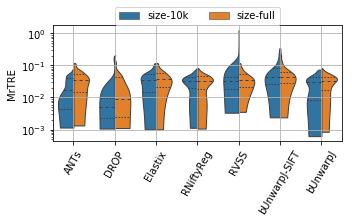

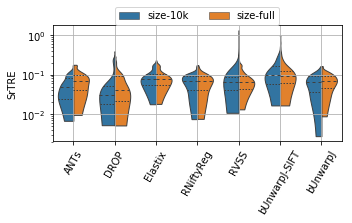

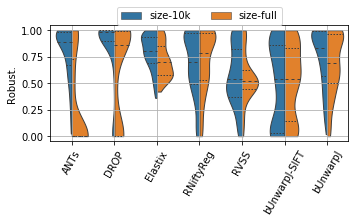

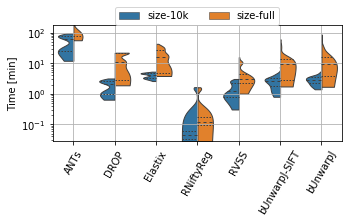

In [7]:
for field, name, log, vmax, bw in [('rTRE-Median', 'MrTRE', True, None, 0.01),
                                   ('rTRE-Max', 'SrTRE', True, None, 0.01),
                                   ('Robustness', 'Robust.', False, None, 0.05),
                                   ('Norm-Time_minutes', 'Time [min]', True, 180, 0.1)]:    
    fig = plt.figure(figsize=(5, 3))
    # clr = sns.palplot(sns.color_palette(tuple(list_methods_colors(df_.columns))))
    sns.violinplot(ax=plt.gca(), data=df_cases, inner="quartile", trim=True, cut=0., linewidth=1.,
                   x="method", y=field, hue="scope", split=True, scale="width", width=0.75)
    _format_ax(fig.gca(), name, log, vmax)
    fig.gca().grid(True)
    lgd = fig.gca().legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
    fig.savefig(os.path.join(PATH_TEMP, 'violin_teams-scores_%s_mixed.pdf' % field),
                bbox_extra_artists=(lgd,), bbox_inches='tight')